# Simple Model
The aim of this workbook it to take an extremely simplified version of the model (just debris) and then build the equations and solve for them to ensure that the model is working correctly before implementing.

In [1]:
import pickle
import sympy as sp
import pandas as pd
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
with open(r'D:\ucl\pyssem\scenario_properties_1.pkl', 'rb') as f:
    scenario_properties = pickle.load(f)

In [56]:
# Define each of the variables that are required
time = scenario_properties.scen_times
# xo is the initial population, this shows for each orbital shell, the initial population
x0 = scenario_properties.x0.Su_260kg[0:10]
# full lambda is the lambda value for the full time period
full_lambda = scenario_properties.full_lambda[0][0:10]

# turn x0 into a list
x0 = x0.tolist()


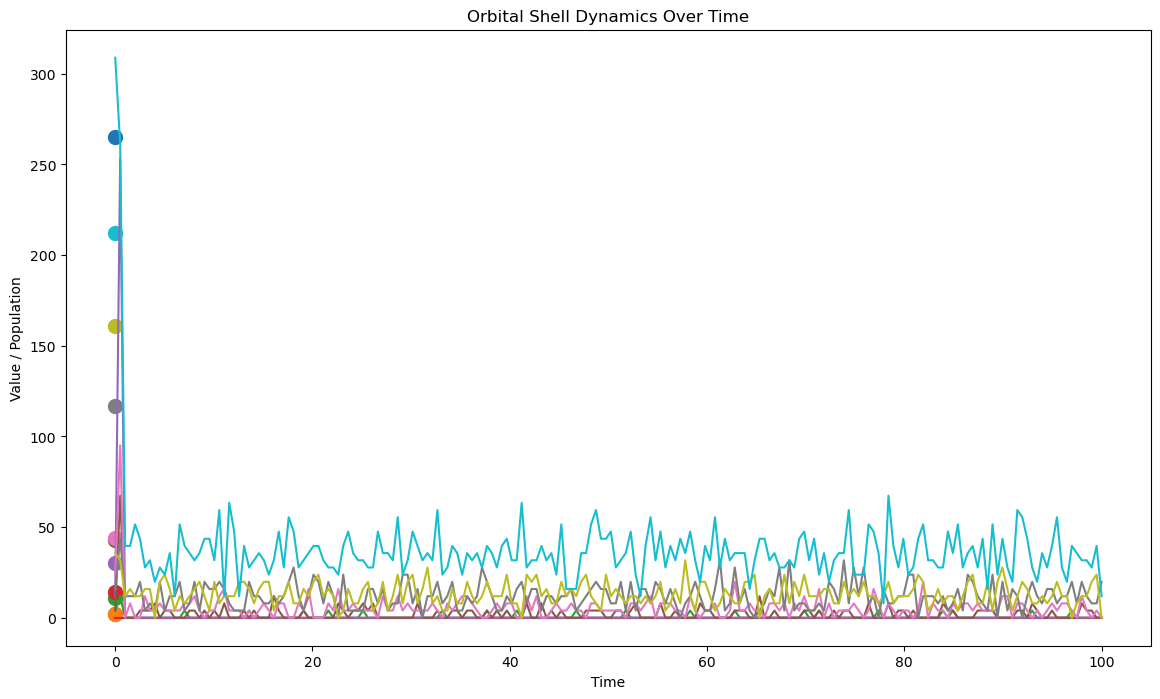

In [57]:
plt.figure(figsize=(14, 8))

# Plot each interpolated function over time
for i, interp_func in enumerate(full_lambda, start=1):
    plt.plot(time, interp_func(time), label=f'Orbital Shell {i} Rate of Change')

# Highlight the initial population for each orbital shell
# Assuming the initial population corresponds to the value at the first time point for simplicity
for i, initial_pop in enumerate(x0, start=1):
    plt.scatter(time[0], initial_pop, label=f'Initial Pop. Shell {i}', marker='o', s=100)  # Adjust marker size as needed

plt.xlabel('Time')
plt.ylabel('Value / Population')
plt.title('Orbital Shell Dynamics Over Time')
plt.show()

In [108]:
sns_symbols = sp.symbols(['sns_' + str(i) for i in range(1, 12)])

# Drag shows the number of objects being removed into the shell below and the number coming in, therefore the difference is the rate of change
full_drag = scenario_properties.full_drag[:, 5][0:10]
drag_funcs = [sp.lambdify(sns_symbols, eq, 'numpy') for eq in full_drag]

full_pmd_ = scenario_properties.full_Cdot_PMD[:,5][0:10]
pmd_funcs = [sp.lambdify(sns_symbols, eq, 'numpy') for eq in full_pmd_]

pmd_funcs

[<function _lambdifygenerated(sns_1, sns_2, sns_3, sns_4, sns_5, sns_6, sns_7, sns_8, sns_9, sns_10, sns_11)>,
 <function _lambdifygenerated(sns_1, sns_2, sns_3, sns_4, sns_5, sns_6, sns_7, sns_8, sns_9, sns_10, sns_11)>,
 <function _lambdifygenerated(sns_1, sns_2, sns_3, sns_4, sns_5, sns_6, sns_7, sns_8, sns_9, sns_10, sns_11)>,
 <function _lambdifygenerated(sns_1, sns_2, sns_3, sns_4, sns_5, sns_6, sns_7, sns_8, sns_9, sns_10, sns_11)>,
 <function _lambdifygenerated(sns_1, sns_2, sns_3, sns_4, sns_5, sns_6, sns_7, sns_8, sns_9, sns_10, sns_11)>,
 <function _lambdifygenerated(sns_1, sns_2, sns_3, sns_4, sns_5, sns_6, sns_7, sns_8, sns_9, sns_10, sns_11)>,
 <function _lambdifygenerated(sns_1, sns_2, sns_3, sns_4, sns_5, sns_6, sns_7, sns_8, sns_9, sns_10, sns_11)>,
 <function _lambdifygenerated(sns_1, sns_2, sns_3, sns_4, sns_5, sns_6, sns_7, sns_8, sns_9, sns_10, sns_11)>,
 <function _lambdifygenerated(sns_1, sns_2, sns_3, sns_4, sns_5, sns_6, sns_7, sns_8, sns_9, sns_10, sns_11)>,
 

In [119]:
x0

[2, 2, 11, 14, 30, 43, 44, 117, 161, 212, 265]

D:\TEMP\ipykernel_9284\1258827565.py:24: RuntimeWarning: invalid value encountered in scalar subtract
  net_change -= drag_funcs[i](*N)
D:\TEMP\ipykernel_9284\1258827565.py:28: RuntimeWarning: invalid value encountered in scalar add
  net_change += drag_funcs[i-1](*N) - drag_funcs[i](*N)


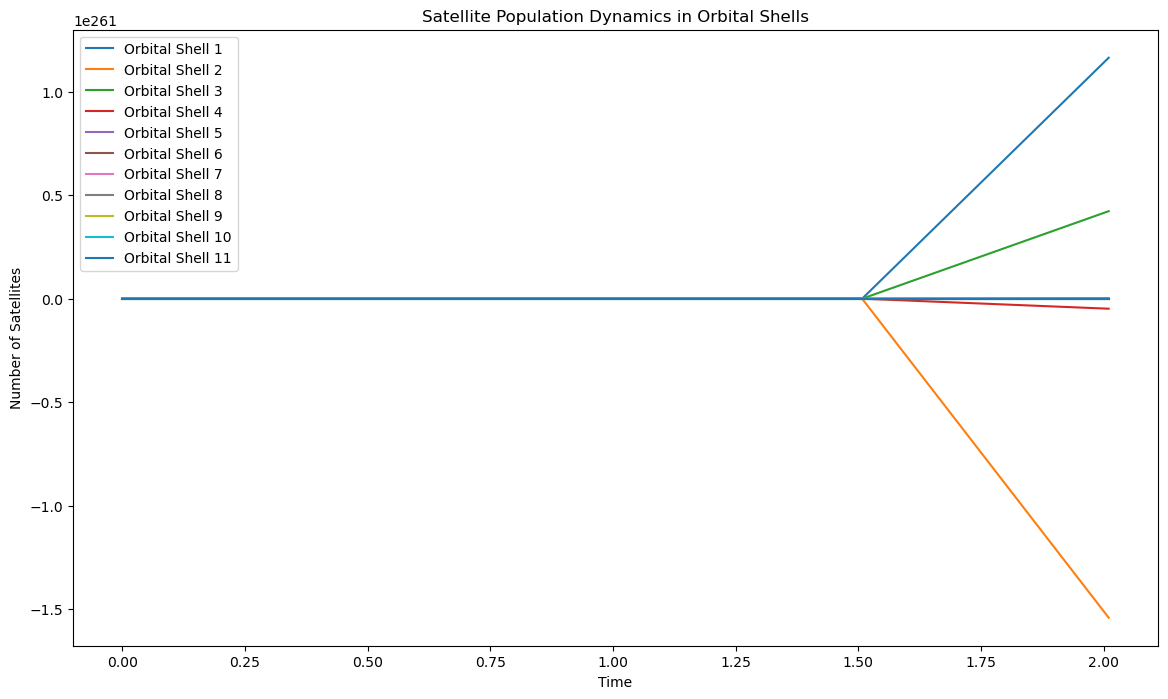

In [116]:
def system_of_odes(t, N, full_lambda, drag_funcs, pmd_funcs):

    # t is going to be the current time
    # n is the intial population of each orbital shell at the current time
    # full_lambda is the launch rate to that shell
    # drag_funcs is the rate of change of objects being removed from the shell, this includes the number of objects being removed from the shell below and the number coming in
    # pmd_funcs is the rate of change of objects being removed from the shell

    dNdt = np.zeros_like(N)
    
    for i in range(len(N)-1):
        # Calculate the rate of change from full_lambda (growth) for shell i
        growth_rate = full_lambda[i](t)
        
        # Calculate the rate of change from pmd_funcs (reduction) for shell i
        # Since pmd_funcs and drag_funcs are now assumed to not require 't', it is omitted
        pmd_rate = pmd_funcs[i](*N)
        
        # Initialize net change for the current shell
        net_change = growth_rate + pmd_rate
        
        # Adjust for drag effects
        if i == 0 and len(N) > 1:
            net_change -= drag_funcs[i](*N)
        elif i == len(N) - 1 and len(N) > 1:
            net_change += drag_funcs[i-1](*N)
        elif i > 0 and i < len(N) - 1:
            net_change += drag_funcs[i-1](*N) - drag_funcs[i](*N)
        
        dNdt[i] = net_change
    
    return dNdt


sol = solve_ivp(system_of_odes, [time[0], time[-1]], x0, args=(full_lambda, drag_funcs, pmd_funcs), t_eval=time, method='RK45')

plt.figure(figsize=(14, 8))
for i in range(sol.y.shape[0]):
    plt.plot(sol.t, sol.y[i], label=f'Orbital Shell {i+1}')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Number of Satellites')
plt.title('Satellite Population Dynamics in Orbital Shells')
plt.show()


-0.389314543569342*sns_11 + 0.390162645990883*sns_12
-3.3*sns_11
<function _lambdifygenerated at 0x000002448923FAF0>
-0.333333333333333*sns_11
<function _lambdifygenerated at 0x000002448A3BB9D0>


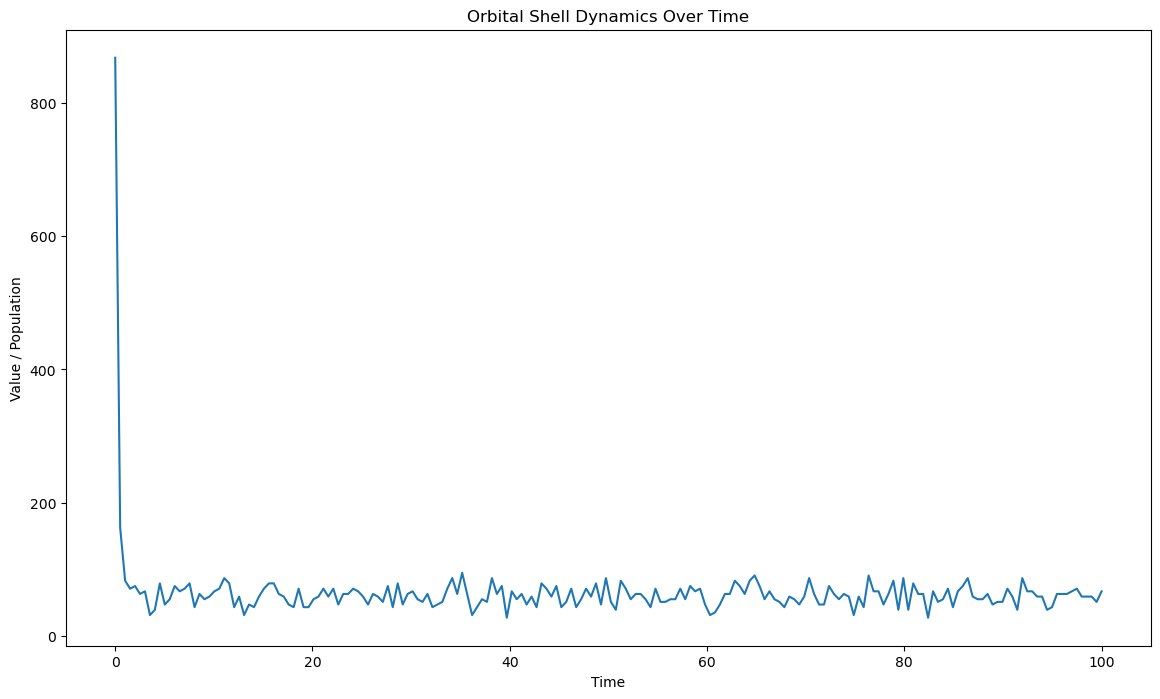

In [201]:
full_lambda = scenario_properties.full_lambda[0][10]


# sns_11, sns_12 = sp.symbols('sns_11 sns_12')
# full_drag = scenario_properties.full_drag[:, 5][10]
# full_drag_updated = full_drag.subs(sns_12, sns_11)
t = sp.symbols('sns_11')  # Define the independent variable, if 't' is involved in your expression
full_drag_updated = -3.30*t
full_drag_callable = sp.lambdify(t, full_drag_updated, 'numpy')
print(full_drag)
print(full_drag_updated)
print(full_drag_callable)


full_pmd = scenario_properties.full_Cdot_PMD[:,5][10]
full_pmd_callable = sp.lambdify(t, full_pmd, 'numpy')
print(full_pmd)
print(full_pmd_callable)

plt.figure(figsize=(14, 8))
plt.plot(time, full_lambda(time), label=f'Orbital Shell {i} Rate of Change')
plt.xlabel('Time')
plt.ylabel('Value / Population')
plt.title('Orbital Shell Dynamics Over Time')
plt.show()

-0.389314543569342*sns_11 + 0.390162645990883*sns_12
-0.3*sns_11
<function _lambdifygenerated at 0x000002448CEF2940>
-0.333333333333333*sns_11
<function _lambdifygenerated at 0x00000244890BDCA0>
265
  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.025e-01 ...  9.950e+01  1.000e+02]
        y: [[ 2.650e+02  5.285e+02 ...  3.383e+03  3.381e+03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 218
     njev: 0
      nlu: 0


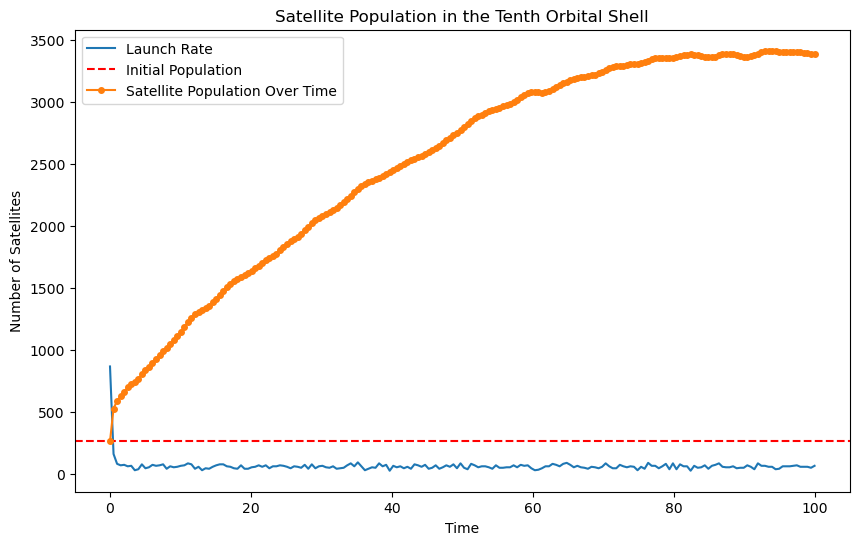

In [225]:
t = sp.symbols('sns_11')  # Define the independent variable, if 't' is involved in your expression
full_drag_updated = -0.3*t
full_drag_callable = sp.lambdify(t, full_drag_updated, 'numpy')
print(full_drag)
print(full_drag_updated)
print(full_drag_callable)


full_pmd = scenario_properties.full_Cdot_PMD[:,5][10]
full_pmd_callable = sp.lambdify(t, full_pmd, 'numpy')
print(full_pmd)
print(full_pmd_callable)


# xo is the initial population, this shows for each orbital shell, the initial population
x0 = scenario_properties.x0.Su_260kg[10]
print(x0)
# full lambda is the lambda value for the full time period


def satellite_ode(t, N, rate_of_change, full_drag, full_pmd):
    # Assuming rate_of_change is a callable that represents your interpolated rate of change function
    r = rate_of_change(t)
    d = full_drag(t)
    p = full_pmd(t)
    
    return r + d + p


# You need to define rate_of_change(t), or replace it with your actual interpolated function call
sol = solve_ivp(satellite_ode, [time[0], time[-1]], [x0], args=(full_lambda, full_drag_callable, full_pmd_callable), t_eval=scenario_properties.scen_times)

plt.figure(figsize=(10, 6))

# Plot the rate of change as previously done
plt.plot(time, full_lambda(time), label='Launch Rate')

# Plot the initial population as a horizontal line
plt.axhline(y=x0, color='r', linestyle='--', label='Initial Population')

# Add the ODE solution to the plot
plt.plot(sol.t, sol.y[0], label='Satellite Population Over Time', marker='o', linestyle='-', markersize=4)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Number of Satellites')
plt.title('Satellite Population in the Tenth Orbital Shell')
plt.show()

In [292]:
full_lambda = scenario_properties.full_lambda[0]

full_drag_updated = scenario_properties.full_drag[:, 5]

x0 = scenario_properties.x0.Su_260kg.to_numpy().tolist()

def satellite_ode(t, N, rate_of_change, full_drag):
    # Assuming rate_of_change is a callable that represents your interpolated rate of change function
    
    # N is going to be each shells current count of the number of satellites
    
    # First we need to calculate the rate of change for each shell
    for i in range(len(N) - 1):  # Adjust loop to avoid out-of-bounds
        r = rate_of_change[i](t)

        sats_curr = N[i]
        sats_upp = N[i+1]
        sns_cur = sp.symbols(f'sns_{i+1}')
        sns_upp = sp.symbols(f'sns_{i+2}')

        # Substitute the current and upper satellite counts directly into the full_drag expression
        drag_expr_substituted = full_drag[i].subs({sns_cur: sats_curr, sns_upp: sats_upp})

        # Since the values are substituted, you can evaluate the expression directly without lambdifying
        drag_value = drag_expr_substituted.evalf()

        print(sats_curr, sats_upp, full_drag[i], drag_value)
        
    return r

sol = solve_ivp(satellite_ode, [scenario_properties.scen_times[0], scenario_properties.scen_times[-1]], x0, args=(full_lambda, full_drag_updated), t_eval=scenario_properties.scen_times)


2.0 2.0 -128.683816759945*sns_1 + 128.976918227467*sns_2 0.586202935044071
2.0 11.0 -57.4616108490442*sns_2 + 57.5918969154298*sns_3 518.587644371640
11.0 14.0 -29.0703333900705*sns_3 + 29.1359487075868*sns_4 88.1296146154397
14.0 30.0 -15.3305671869121*sns_4 + 15.3650146578452*sns_5 246.322499118586
30.0 43.0 -8.78182184665379*sns_5 + 8.80146613997881*sns_6 115.008388619475
43.0 44.0 -5.0217822541681*sns_6 + 5.03296558123505*sns_7 5.51384864511371
44.0 117.0 -2.86662817121224*sns_7 + 2.87298374096755*sns_8 210.007458159865
117.0 161.0 -1.70625635826803*sns_8 + 1.71002258033384*sns_9 75.6816415163878
161.0 212.0 1.02969352618743*sns_10 - 1.02743563377436*sns_9 52.8778905140623
212.0 265.0 -0.62880586333014*sns_10 + 0.630181680015946*sns_11 33.6913021782362
265.0 1705.0 -0.389314543569342*sns_11 + 0.390162645990883*sns_12 562.058957368579
1705.0 186.0 -0.243838554933805*sns_12 + 0.244367440824249*sns_13 -370.292392168828
186.0 31.0 -0.152721446442234*sns_13 + 0.153051268530084*sns_14 -2

In [314]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Assuming the full_lambda function is defined correctly outside this snippet
# and full_drag_updated contains numerical rates or is a function that can be directly applied.

def satellite_ode(t, N, rate_of_change, full_drag):
    # Assuming rate_of_change is a callable that represents your interpolated rate of change function
    
    #print(len(N))
    # N is going to be each shells current count of the number of satellites
    out = []
    # First we need to calculate the rate of change for each shell
    for i in range(len(N)):  # Adjust loop to avoid out-of-bounds
        
        r = rate_of_change[i](t)

        sats_curr = N[i]
        try:
            sats_upp = N[i+1]
        except IndexError:
            sats_upp = 0 # Top shell
        
        sns_cur = sp.symbols(f'sns_{i+1}')
        sns_upp = sp.symbols(f'sns_{i+2}')

        # Substitute the current and upper satellite counts directly into the full_drag expression
        drag_expr_substituted = full_drag[i].subs({sns_cur: sats_curr, sns_upp: sats_upp})

        # Since the values are substituted, you can evaluate the expression directly without lambdifying
        drag_value = drag_expr_substituted.evalf()

        out.append(r + drag_value)

        # print(i, sats_curr, sats_upp)

    return out


# Solve the system of ODEs
sol = solve_ivp(satellite_ode, [scenario_properties.scen_times[0], scenario_properties.scen_times[-1]], x0, args=(full_lambda, full_drag_updated), t_eval=scenario_properties.scen_times, method='RK45')

# Plotting the results
plt.figure(figsize=(10, 6))

for i in range(sol.y.shape[0]):
    plt.plot(sol.t, sol.y[i], label=f'Shell {i+1}')

plt.xlabel('Time')
plt.ylabel('Number of Satellites')
plt.title('Satellite Population Dynamics')
plt.legend()
plt.show()


39
0 2.0 2.0
1 2.0 11.0
2 11.0 14.0
3 14.0 30.0
4 30.0 43.0
5 43.0 44.0
6 44.0 117.0
7 117.0 161.0
8 161.0 212.0
9 212.0 265.0
10 265.0 1705.0
11 1705.0 186.0
12 186.0 31.0
13 31.0 20.0
14 20.0 6.0
15 6.0 21.0
16 21.0 2.0
17 2.0 3.0
18 3.0 6.0
19 6.0 1.0
20 1.0 0.0
21 0.0 11.0
22 11.0 7.0
23 7.0 16.0
24 16.0 4.0
25 4.0 0.0
26 0.0 1.0
27 1.0 2.0
28 2.0 5.0
29 5.0 0.0
30 0.0 8.0
31 8.0 44.0
32 44.0 286.0
33 286.0 28.0
34 28.0 0.0
35 0.0 0.0
36 0.0 0.0
37 0.0 0.0
38 0.0 0
[0.586202935044071, 518.587644371640, 92.0897550087687, 246.322499118586, 126.888809799462, 9.47398903844272, 233.768300519839, 91.5222030897039, 88.5191540540234, 342.582252857899, 1429.32970350763, 2516.64995456802, 0.0992426461510796, 50.4245778112021, 10.9896303655569, 0.632396160323872, 23.2338389753556, 3.97982559374178, 4.00224368637162, -0.0499034030533588, 3.95264978770022, 0.0650407317732464, 19.7821775411967, 0.0334877303197288, -0.0377459247185569, -0.0106899162258847, 0.00227364344387584, 0.00202286654438149

KeyboardInterrupt: 